# RF microstrip: quarter wave stub filter

## Overview
We simulate a quarter wave stub bandstop filter in RF microstrip with nominal 3.5GHz notch. Compare with [OpenEMS example](https://docs.openems.de/python/openEMS/Tutorials/MSL_NotchFilter.html)

## Geometry

running luminescent python frontend


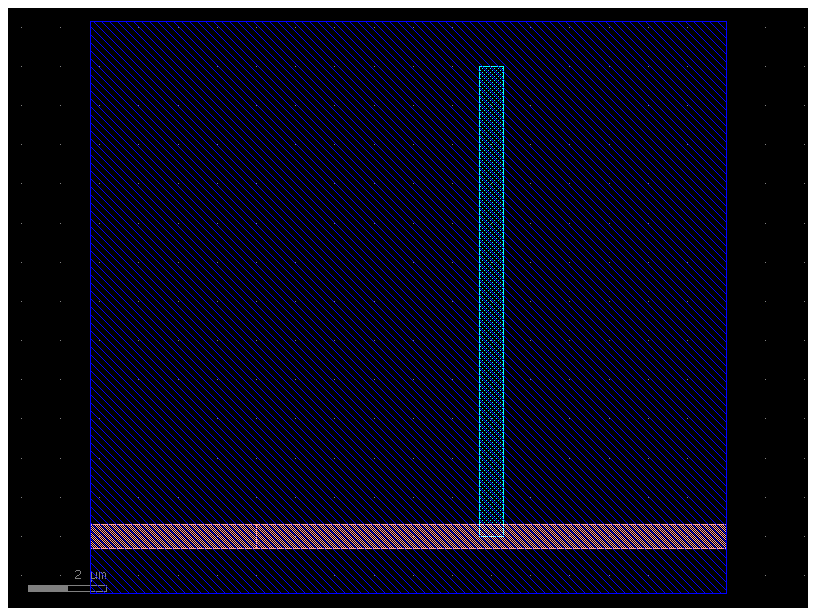

In [1]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

path = os.path.join("runs", "stub")

# length and frequency units are arbitrary so long as they are consistent. Here we use mm and GHz.
frequency = 3.5  # GHz
wl1f = 300  # vacuum wavelength at 1 unit of frequency, all  in your units
wl = wl1f / frequency  # characteristic wavelength
frequencies = np.linspace(1, 6, 101).tolist()

# microstrip
w_line = .6  # width of microstrip line
d = 0.254  # substrate depth
th=.01 # metal thickness
l_stub=12
l_line = l_stub

lateral_port_margin = height_port_margin = 3 * d
xmargin = zmargin = 1.5 * lateral_port_margin
source_port_margin = 2 * (w_line + 2 * lateral_port_margin)

# layers
FEED = 1, 0
STUB = 2, 0
SUB = 10, 0

# make geometry in gdsfadory
# alternatively can import .gds into gdsfadory
c = gf.Component()
line = c << lumi.straight(length=l_line, width=w_line,layer=FEED)
stub = c << lumi.straight(length=l_stub, width=w_line,layer=STUB)
stub.rotate(90)
stub.movex(l_line / 2)
# stub.movey(-w_line / 2)
ext = c << lumi.straight(source_port_margin, width=w_line, layer=FEED)
ext.connect("o2", line.ports["o1"])

for i in (1, 2):
    c.add_port(f"o{i}", port=line.ports[f"o{i}"])

c << gf.components.bbox(component=c, layer=SUB, top=xmargin, bottom=xmargin)
c.plot()

## Solve

Solving port modes with FEM...


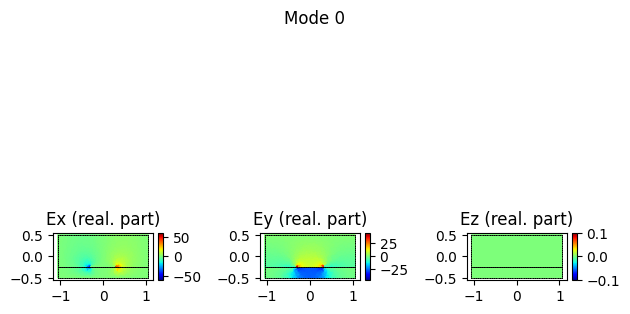

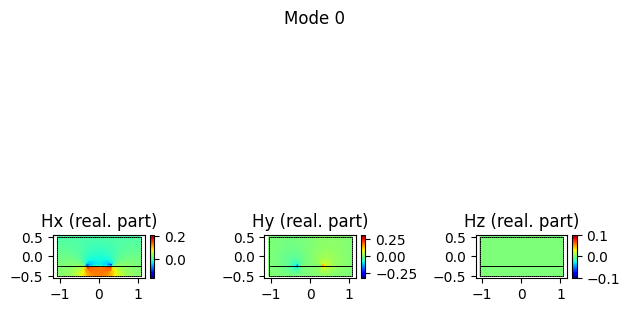

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub
loading problem from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub



FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
# adaptive meshing
nres = 16
dx0 = wl / nres

layer_stack = LayerStack(
    layers={
        "feed": LayerLevel(
            layer=LogicalLayer(layer=FEED),
            zmin=d,
            thickness=th,
            material="PEC_feed",
            mesh_order=10,
        ),
        "stub": LayerLevel(
            layer=LogicalLayer(layer=STUB),
            zmin=d,
            thickness=th,
            material="PEC_stub",
            mesh_order=20,
        ),
        "sub": LayerLevel(
            layer=LogicalLayer(layer=SUB),
            zmin=0.0,
            thickness=d,
            material="substrate",
            mesh_order=30,
        ),
    }
)

# materials
eps_substrate = 3.66
n_substrate = np.sqrt(eps_substrate) 

dx = w_line / 4 # 4 mesh points across the strip
n_line_width = dx0 / (dx) # mesh density relative to vacuum  

materials_library = {
    'substrate': lumi.Material(epsilon=eps_substrate),
    'PEC_feed': lumi.PECMaterial(mesh_density=[n_substrate,n_line_width,1]),
    'PEC_stub': lumi.PECMaterial(mesh_density=[n_line_width,n_substrate,1]),
}
materials_library["background"] = lumi.Material(epsilon=1.0)

modes = [
    lumi.Mode(
        frequency=frequency,
        metallic_boundaries=["-y", "feed"],
        nmodes=1,
    )
]

sources = [
    lumi.Source(
        "o1", frequency=frequency, duration=.5, source_port_margin=source_port_margin
    )
]

kwargs = dict(
    path=path,
    component=c,
    frequency=frequency,
    frequencies=frequencies,
    wl1f=wl1f,
    boundaries=["PML", "PML", ["PEC", "PML"]],
    #
    sources=sources,
    #
    modes=modes,
    lateral_port_margin=lateral_port_margin,
    height_port_margin=[0, height_port_margin],
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    core="sub",
    zmin=0.0,
    zmax=d + zmargin,
    #
    nres=nres,
    relative_courant=0.9,  # relative courant number between 0 and 1
    relative_pml_depths=[1, 0.3, 0.3],
    Tsim=10,  # max time
    subpixel_smoothing=False,
    field_decay_threshold=0.01,  # field decay threshold for stopping simulation
    # visualization
    field_slices=[-source_port_margin, 0, d / 2],
    geometry_slices=[-source_port_margin, 0, d + th / 2],
    show_field="Ez",
    #
    saveat=0.5,  # save frame for plotting every _ periods
    force=True,  # override and delete simulation folder
    gpu="CUDA",  # use GPU acceleration
)


lumi.make_prob(**kwargs)
lumi.solve(path,False)

lumi.make_movie(path)
display(Image(os.path.join(path, "peak.png")))
display(Image(os.path.join(path, "simulation.gif")))

runs\stub
setting up simulation...
meshing geometry (can take few minutes on Google Colab free tier due to low CPU core count)...
all trees: 9.143505 seconds (17.22 M allocations: 11.904 GiB, 21.17% gc time, 495.96% compilation time)
 17.513857 seconds (74.31 M allocations: 15.173 GiB, 14.05% gc time, 544.47% compilation time: <1% of which was recompilation)
  0.375846 seconds (2.36 M allocations: 224.368 MiB, 15.68% gc time, 62.95% compilation time)
PEC detected
  1.250758 seconds (8.91 M allocations: 721.099 MiB, 7.90% gc time, 36.05% compilation time)
  0.822243 seconds (8.05 M allocations: 677.080 MiB, 13.35% gc time)
  0.771551 seconds (8.05 M allocations: 676.853 MiB, 13.53% gc time)
  0.648265 seconds (8.05 M allocations: 677.053 MiB, 13.73% gc time)
  0.646145 seconds (8.01 M allocations: 673.506 MiB, 13.01% gc time)
  0.600196 seconds (8.01 M allocations: 673.506 MiB, 13.86% gc time)
making sources...
making monitors...
making designs...
---------------------------------------

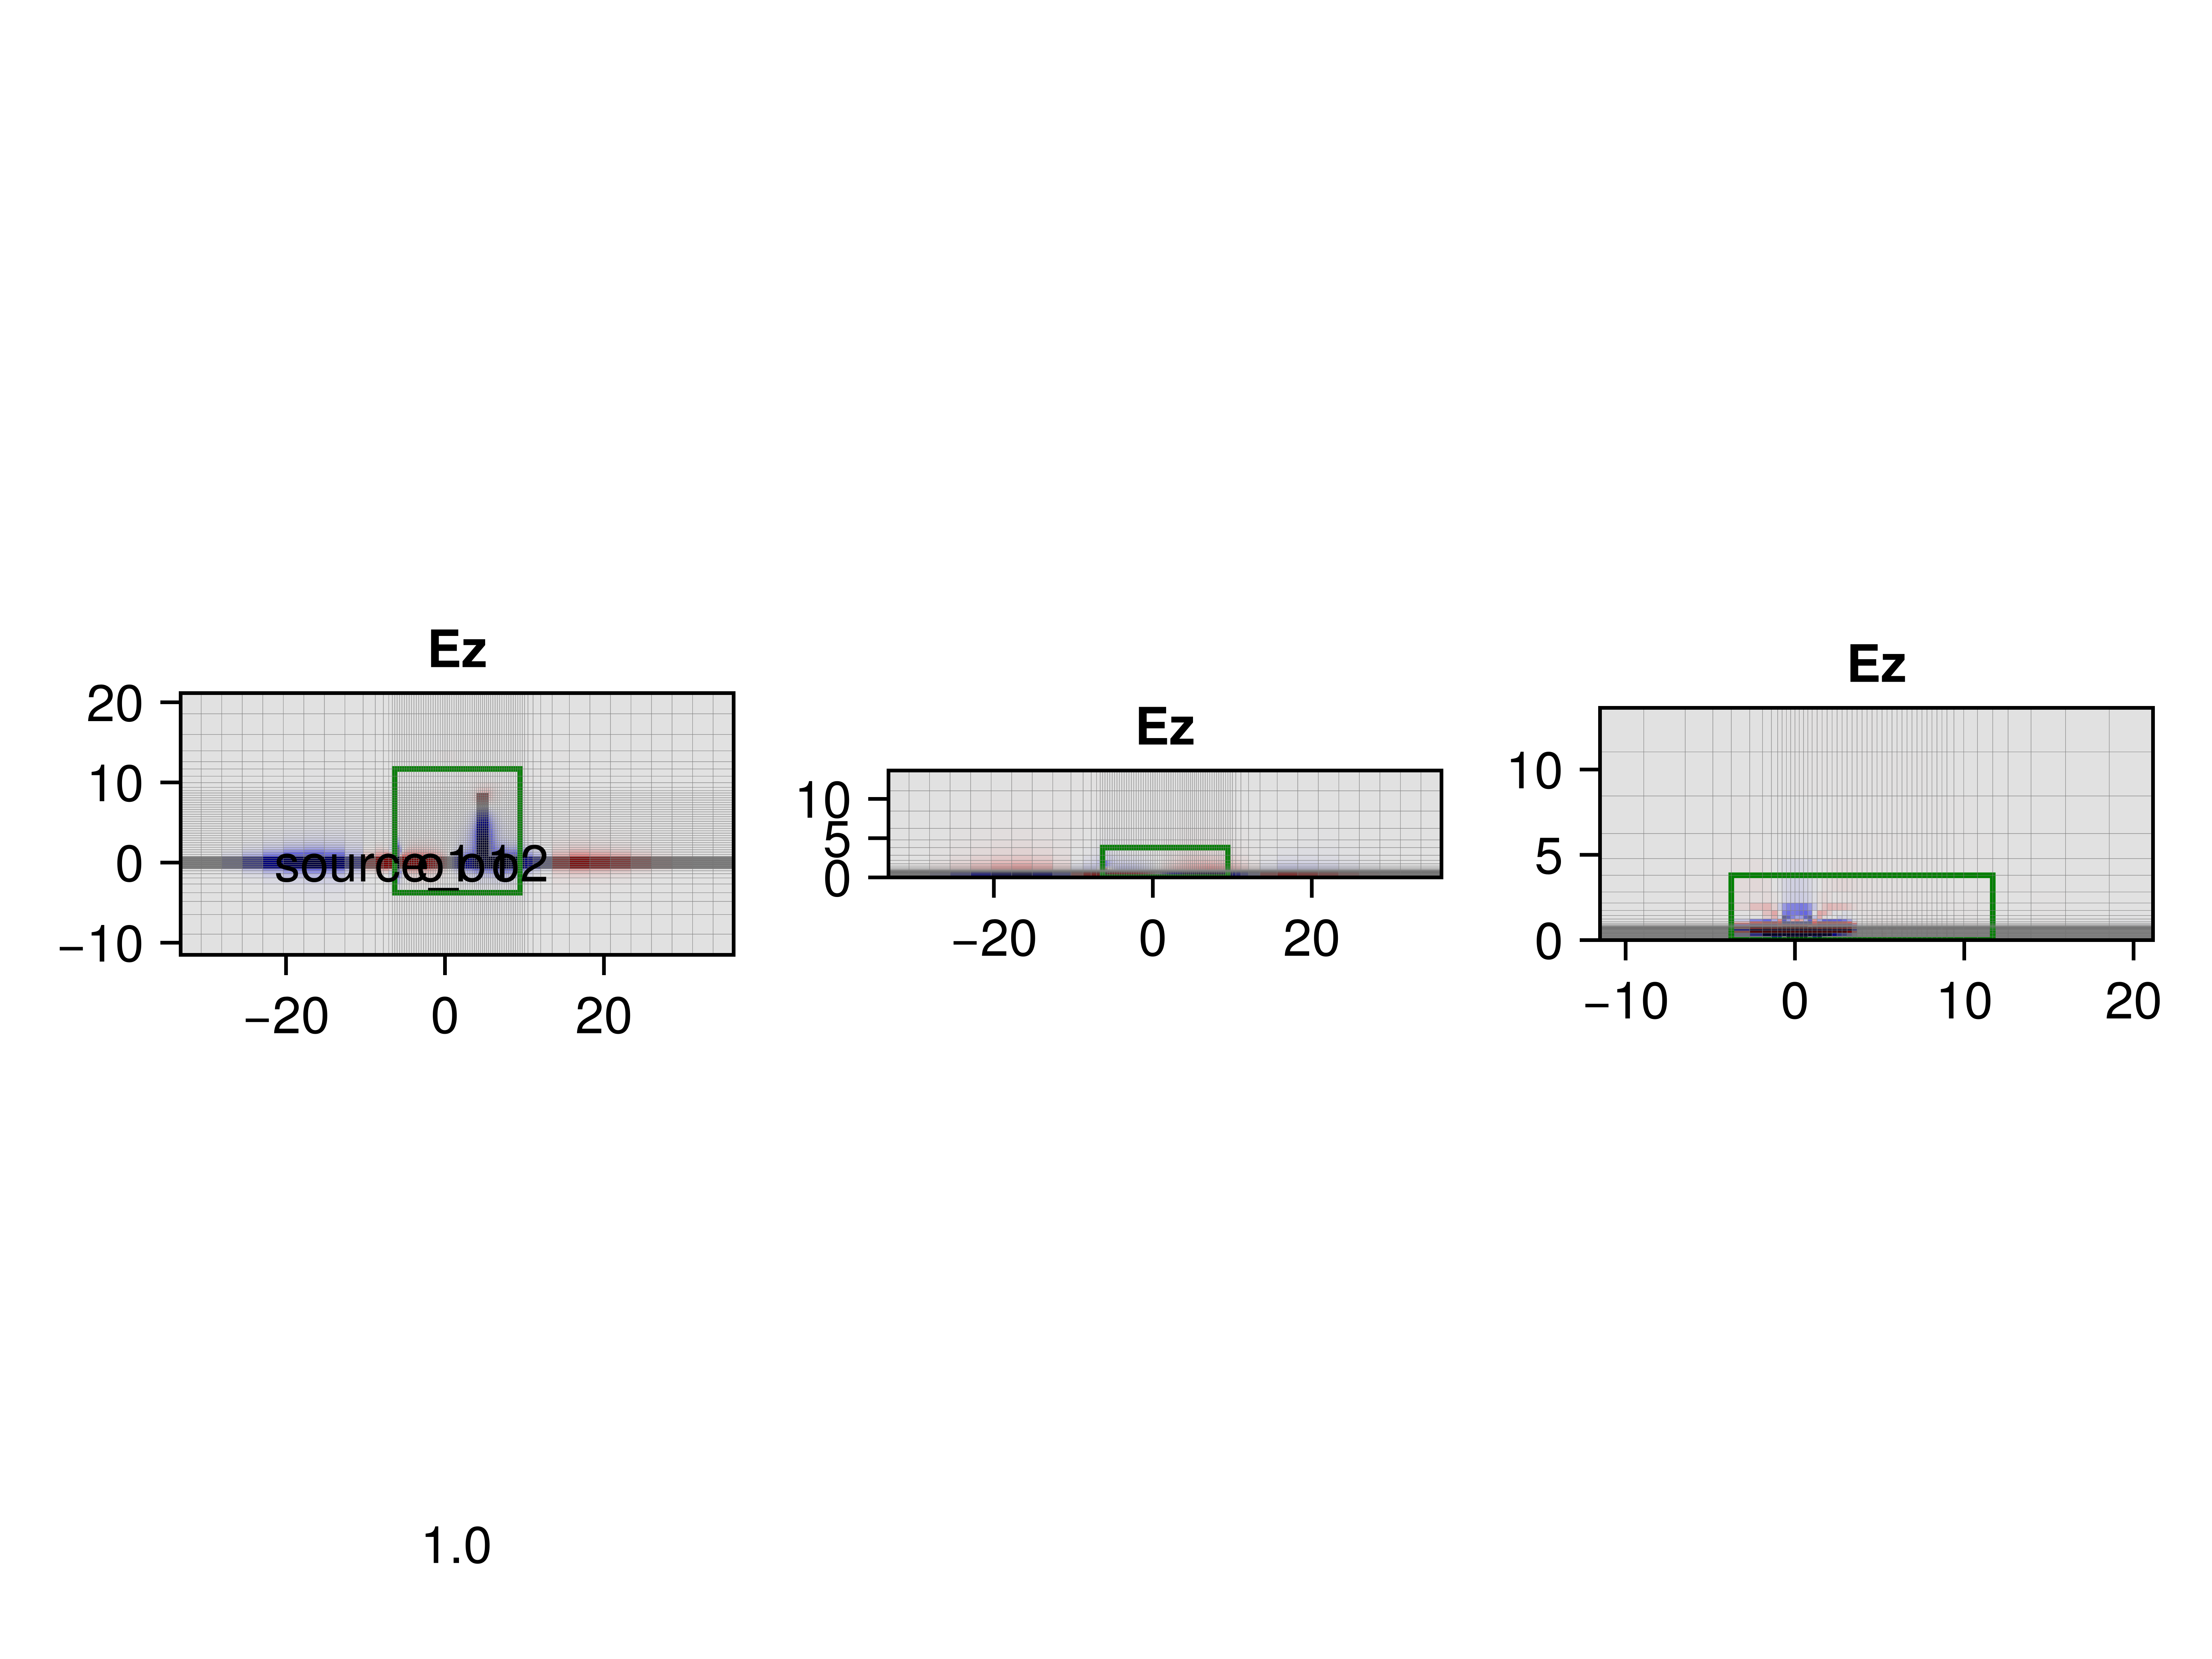

## Analysis

loading solution from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\runs\stub


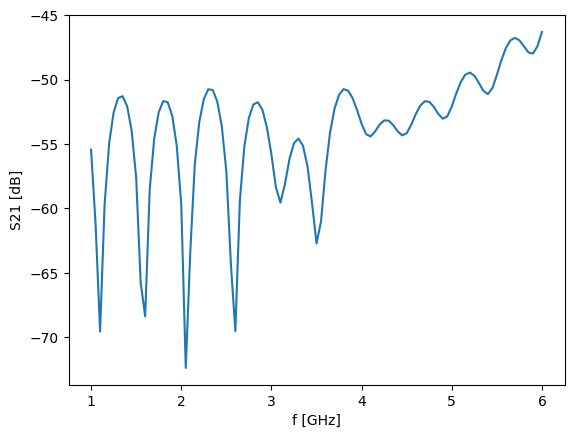

In [4]:
import math

sol = lumi.load_sol(path)
x = frequencies
# y = lumi.query(sol, "To2@0,o1@0")
y = lumi.query(sol, "T2,1")
y = [10 * math.log10(v) for v in y]
plt.plot(x, y)
plt.xlabel("f [GHz]")
plt.ylabel("S21 [dB]")
plt.show()

In [ ]:
# from IPython.display import Video
# lumi.make_movie(path)
# video = Video(os.path.join(path, "simulation.mp4"),embed=True)
# display(video)